In [2]:
import numpy as np
import pandas as pd
import yfinance as yf # Yahoo Finance API
from datetime import datetime
from pprint import pprint # make printing data more readable
from treasury.client import FederalTreasuryClient # Fedearal Open Source Treasury API
import matplotlib.pyplot as plt # just in case we need to graph
# ticker_symbol_input = yf.Ticker("MSFT")
# print(ticker_symbol_input.info)

Current date 2022-11-11; difference between dates 0.0; upper case ticker TSLA; market 195.74; dividend rate 0: 
Got error from yahoo api for ticker TSLA=F, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TSLA=F: No data found for this date range, symbol may be delisted


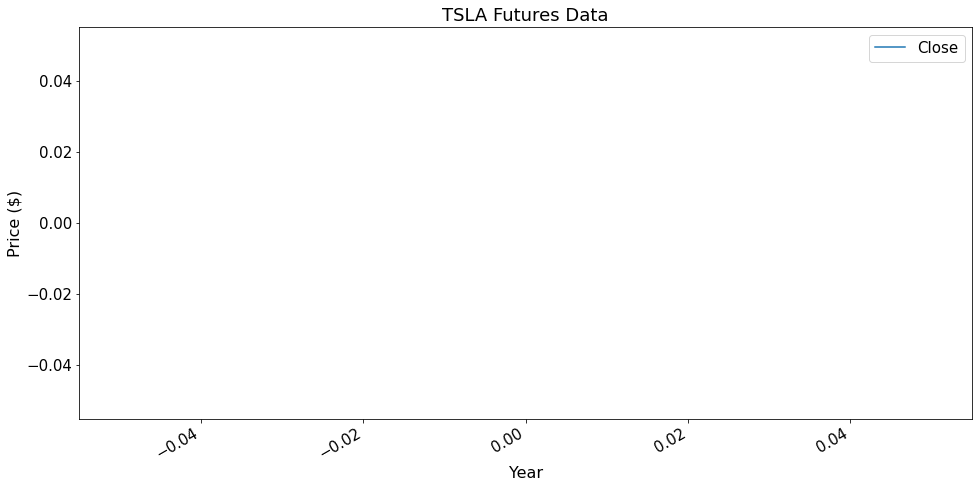

In [3]:
# parent/super class
class EDWARD_dashboard:
    def __init__(self, ticker_symbol: str, exercise_price: float, expiration_date: str, captial: float, risk_tol: float):
        self.ticker_symbol = ticker_symbol.upper()
        self.current_date = datetime.now().strftime("%Y-%m-%d")
        # self.contract_type = contract_type
        self.exercise_price = exercise_price
        self.expiration_date = expiration_date
        self.captial = capital
        self.risk_tol = risk_tol

    def days_between(self):
        d1, d2 = datetime.strptime(self.current_date, "%Y-%m-%d"), datetime.strptime(self.expiration_date, "%Y-%m-%d")
        diff_times = (abs((d2 - d1).days))/365
        return diff_times

    def market_price(self):
        ticker_symbol = yf.Ticker(self.ticker_symbol).info
        market_price = ticker_symbol['regularMarketPrice']
        return market_price # spot price

    def risk_free_rate(self):
        # still need to use API to find nominal_rate and inflation_rate
        risk_free_rate = ((1+nominal_rate)/(1+inflation_rate))
        return risk_free_rate

    def dividend_yield(self):
        ticker_symbol = yf.Ticker(self.ticker_symbol).info
        dividend_rate = ticker_symbol['dividendRate']
        if dividend_rate == None:
            dividend_rate = 0
        return dividend_rate


    def futures_formula(self):
        Price_contract =  self.market_price()*np.e**((self.risk_free_rate()-self.dividend_yield())*(self.days_between()))
        return Price_contract


    def portfolio(self):
        ticker_symbol = yf.Ticker(self.ticker_symbol)
        pass

    def __str__(self):
        return f"Current date {str(self.current_date)}; difference between dates {str(self.days_between())}; upper case ticker {self.ticker_symbol}; market {self.market_price()}; dividend rate {self.dividend_yield()}: "

tesla = EDWARD_dashboard("tSlA","future",300,"2022-11-11")
print(tesla)
# print(tesla.futures_formula())
# tesla.options_data('calls')
# tesla.options_data('puts')
a = tesla.futures_data()
tesla.futures_plot(a)

In [18]:
# User Inputs
input_symbol = input("Ticker Symbol you would like to use? ")
# ticker_symbol = yf.Ticker(input_symbol)
capital = input("How much Capital would you like to invest ")
risk_tol = input("How much Capital would you like to invest ")
input_exercise_price = int(input("What price would you like to exercise the shares at? "))
input_expiration_date = input("What date would you like to set the expiration? (Y-M-D)")
# EDWARD_dashboard(input_symbol, input_exercise_price, input_expiration_date, capital, risk_tol)


ValueError: invalid literal for int() with base 10: ''

In [ ]:
"""
Risk Free Rate Calculator based on 3-Month US treasury Bill Rates
Author: ranaroussi
link: https://gist.github.com/ranaroussi/72d0e92bbe31d1514baccf00175049e4
"""
# de-annualize yearly interest rates
def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

def get_risk_free_rate():
    # download 3-month us treasury bills rates
    annualized = yf.download("^IRX")["Adj Close"]

    # de-annualize
    daily = annualized.apply(deannualize)

    # create dataframe
    return pd.DataFrame({"annualized": annualized, "daily": daily})

if __name__ == "__main__":
    rates = get_risk_free_rate()
    print(rates.tail())